# PA005 - High Value Customers Identification (Insiders)

# 0.0 Imports

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import umap.umap_ as umap
import sqlite3
import pickle
import s3fs


from scipy.cluster import hierarchy as hc
from plotly import express as px
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import preprocessing as pp
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn import mixture as mx
from sklearn.neighbors import NearestNeighbors

## 0.2 Loading Dataset

In [2]:
# load data
path = '/home/tiagobarreto/DS/repos/clusterização/pa005_clustering'
df_raw = pd.read_csv(path +'/data/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis = 1)

# 1.0 Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id','country']
df1.columns = cols_new

## 1.2 Data Dimensions, Types e NA

In [5]:
df1.shape

(541909, 8)

## 1.3 Datatypes

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
# remove na
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

invoice_number_missing = df_missing.loc[:, 'invoice_no'].tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(invoice_number_missing), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [9]:
df_not_missing['customer_id'].max()

18287.0

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing[['invoice_no']].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge with original dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

## 1.6 Change Datatypes

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendecy (Mean and Median)
c1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean(x)))
c2 = pd.DataFrame(num_attributes.apply(lambda x: np.median(x)))

# Dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: (x).min()))
d2 = pd.DataFrame(num_attributes.apply(lambda x: (x).max()))
d3 = pd.DataFrame(num_attributes.apply(lambda x: (x).max() - (x).min()))
d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x)))
d5 = pd.DataFrame(num_attributes.apply(lambda x: (x).skew()))
d6 = pd.DataFrame(num_attributes.apply(lambda x: (x).kurtosis()))

a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']
a

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2 Categorical Attributes

In [14]:
# invoice_no

# df1['invoice_no'] = df1['invoice_no'].astype(int)
df_invoice_no = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), :]
quantity_negative = df_invoice_no.loc[df_invoice_no['quantity'] < 0, 'quantity'].count()

print(f'Quantidade de invoice number com letras: {df_invoice_no.shape[0]} e que tem quantidade negativa: {quantity_negative}')

Quantidade de invoice number com letras: 9291 e que tem quantidade negativa: 9288


In [15]:
# stock_code

# df1['stock_code'] = df1['stock_code'].astype(int)
# len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), 'stock_code'].drop_duplicates())

stock_code_limpeza = list(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x) ) ), 'stock_code'].unique())

print(f'Lista de stock code para limpar: {stock_code_limpeza}')

Lista de stock code para limpar: ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']


In [16]:
# country_code
cat_attributes.loc[:, 'country'].value_counts(normalize = True)
cat_attributes.loc[:, 'country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 2.0 Filtragem de Variáveis

In [17]:
df2 = df1.copy()

In [18]:
# ======== unit_price ========
df2 = df2[df2['unit_price'] >= 0.04]

# ======== stock_code ========
df2 = df2[~df2['stock_code'].isin(stock_code_limpeza)]

# ======== description ========
df2 = df2.drop(columns='description', axis = 1)
 
# ======== country ========
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# ======== bad users ========
df2 = df2[~(df2['customer_id'].isin( [16446, 15749] ))]

# ======== quantity ========
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]


# 3.0 Feature Enginnering

In [19]:
df3 = df2.copy()

## 3.1 Feature Creation

In [20]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity','invoice_date','unit_price','country'], axis = 1).drop_duplicates(ignore_index = True)

### 3.1.1 Gross Revenue

In [21]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on ='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_2884/4216613857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency Days from the last purchase

In [22]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchases

In [23]:
df_purch = df2_purchases.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'purchases'})
df_ref = pd.merge(df_ref, df_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
purchases        91
dtype: int64

### 3.1.5 Quantity of Items purchased

In [24]:
df_items_purch = df2_purchases.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'items_purchased'})
df_ref = pd.merge(df_ref, df_items_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
purchases          91
items_purchased    91
dtype: int64

### 3.1.6 Avg Ticket Value

In [25]:
df_gross = df2_purchases.loc[:, ['customer_id', 'invoice_no','gross_revenue']].groupby(['customer_id','invoice_no']).sum().reset_index()
df_ticket = df_gross.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on ='customer_id', how='left')
df_ref.isna().sum()


customer_id         0
gross_revenue      91
recency_days       91
purchases          91
items_purchased    91
avg_ticket         91
dtype: int64

### 3.1.7 Avg Recency Days

In [26]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(columns=['invoice_date', 'next_customer_id', 'previous_date'], axis = 1).dropna()

df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_avg_recency_days, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
purchases             91
items_purchased       91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.9 Number of Orders Returned

In [27]:
# Number of Returns
df_number_returns = df2_returns.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no': 'number_returns'})
df_ref = pd.merge(df_ref, df_number_returns, on ='customer_id', how='left')
df_ref.loc[df_ref['number_returns'].isna(), 'number_returns'] = 0  
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
purchases             91
items_purchased       91
avg_ticket            91
avg_recency_days    2816
number_returns         0
dtype: int64

### 3.1.10 Monetary value of returns

In [28]:
# Number of Returns
df2_returns['monetary_returns'] = df2_returns.loc[:, ['customer_id','quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'] * (-1), axis = 1)
df2_monetary_returns = df2_returns.loc[:, ['customer_id','monetary_returns']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df2_monetary_returns, on ='customer_id', how='left')
df_ref.loc[df_ref['monetary_returns'].isna(), 'monetary_returns'] = 0  
df_ref.isna().sum()

/tmp/ipykernel_2884/2122528216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_returns['monetary_returns'] = df2_returns.loc[:, ['customer_id','quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'] * (-1), axis = 1)


customer_id            0
gross_revenue         91
recency_days          91
purchases             91
items_purchased       91
avg_ticket            91
avg_recency_days    2816
number_returns         0
monetary_returns       0
dtype: int64

### 3.1.13 Delta_buy_return

In [29]:
df_ref['delta_buy_return'] = df_ref['monetary_returns'] / df_ref['gross_revenue'] 

# 4.0 EDA

In [67]:
df4 = df_ref.dropna()


## 4.3 Estudo do Espaço

In [68]:
feature_selected = ['items_purchased',
 'avg_ticket',
 'number_returns',
 'monetary_returns',
 'delta_buy_return','recency_days']

In [69]:
df43 = df4.drop(columns=['customer_id'], axis = 1).copy()


In [70]:
mms_gross_revenue = pp.MinMaxScaler()
mms_recency_days = pp.MinMaxScaler()
mms_items_purchased = pp.MinMaxScaler()
mms_avg_ticket = pp.MinMaxScaler()
mms_number_returns = pp.MinMaxScaler()
mms_monetary_returns = pp.MinMaxScaler()
mms_delta_buy_return = pp.MinMaxScaler()

In [71]:
df43['gross_revenue'] = mms_gross_revenue.fit_transform(df43[['gross_revenue']])
pickle.dump(mms_gross_revenue, open('../src/features/mms_gross_revenue.pkl', 'wb'))

df43['recency_days'] = mms_recency_days.fit_transform(df43[['recency_days']])
pickle.dump(mms_recency_days, open('../src/features/mms_recency_days.pkl', 'wb'))

df43['items_purchased'] = mms_items_purchased.fit_transform(df43[['items_purchased']])
pickle.dump(mms_items_purchased, open('../src/features/mms_items_purchased.pkl', 'wb'))

df43['avg_ticket'] = mms_avg_ticket.fit_transform(df43[['avg_ticket']])
pickle.dump(mms_avg_ticket, open('../src/features/mms_avg_ticket.pkl', 'wb'))

df43['number_returns'] = mms_number_returns.fit_transform(df43[['number_returns']])
pickle.dump(mms_number_returns, open('../src/features/mms_number_returns.pkl', 'wb'))

df43['monetary_returns'] = mms_monetary_returns.fit_transform(df43[['monetary_returns']])
pickle.dump(mms_monetary_returns, open('../src/features/mms_monetary_returns.pkl', 'wb'))

df43['delta_buy_return'] = mms_delta_buy_return.fit_transform(df43[['delta_buy_return']])
pickle.dump(mms_delta_buy_return, open('../src/features/mms_delta_buy_return.pkl', 'wb'))


X = df43[feature_selected].copy()
y = df4['gross_revenue'].copy()

In [77]:
# dump to S3
fs = s3fs.S3FileSystem()
pickle.dump(mms_gross_revenue, fs.open('s3://insiders-dataset-ttb/mms_gross_revenue.pkl', 'wb'))
pickle.dump(mms_recency_days, fs.open('s3://insiders-dataset-ttb/mms_recency_days.pkl', 'wb'))
pickle.dump(mms_items_purchased, fs.open('s3://insiders-dataset-ttb/mms_items_purchased.pkl', 'wb'))
pickle.dump(mms_avg_ticket, fs.open('s3://insiders-dataset-ttb/mms_avg_ticket.pkl', 'wb'))
pickle.dump(mms_number_returns, fs.open('s3://insiders-dataset-ttb/mms_number_returns.pkl', 'wb'))
pickle.dump(mms_monetary_returns, fs.open('s3://insiders-dataset-ttb/mms_monetary_returns.pkl', 'wb'))
pickle.dump(mms_delta_buy_return, fs.open('s3://insiders-dataset-ttb/mms_delta_buy_return.pkl', 'wb'))

### 4.3.4 Tree Based Embedding

In [35]:
# model definition
# rf_model = RandomForestRegressor(n_estimators= 250, random_state=42)
rf_model = pickle.load(open(path+'/models/rf_model.pkl', 'rb'))

# model training
# rf_model.fit(X, y)

# df leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

# pickle.dump(rf_model, open('/home/tiagobarreto/DS/repos/clusterização/pa005_clustering/models/rf_model.pkl', 'wb'))

In [ ]:
reducer = umap.UMAP(n_components= 10, random_state= 42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
# df_tree
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
df_tree['embedding_z'] = embedding[:, 2]
df_tree['embedding_a'] = embedding[:, 3]
df_tree['embedding_b'] = embedding[:, 4]
df_tree['embedding_c'] = embedding[:, 5]
df_tree['embedding_d'] = embedding[:, 6]
df_tree['embedding_e'] = embedding[:, 7]
df_tree['embedding_f'] = embedding[:, 8]
df_tree['embedding_g'] = embedding[:, 9]



# df4 
df4['embedding_x'] = embedding[:, 0]
df4['embedding_y'] = embedding[:, 1]
df4['embedding_z'] = embedding[:, 2]
df4['embedding_a'] = embedding[:, 3]
df4['embedding_b'] = embedding[:, 4]
df4['embedding_c'] = embedding[:, 5]
df4['embedding_d'] = embedding[:, 6]
df4['embedding_e'] = embedding[:, 7]
df4['embedding_f'] = embedding[:, 8]
df4['embedding_g'] = embedding[:, 9]



In [90]:
pickle.dump(reducer, fs.open('s3://insiders-dataset-ttb/reducer.pkl', 'wb'))

# 5.0 Data Preparation

# 7.0 HyperParameter Fine-Tunning

In [79]:
X = df_tree.copy()

In [80]:
clusters = np.arange(2, 26, 1)

## 7.1 K-Means

In [81]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters= k)

    # model fit
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    ss = mt.silhouette_score(X, labels)
    kmeans_list.append(ss)

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/clust

Text(0.5, 1.0, 'Silhouette x K - Kmeans')

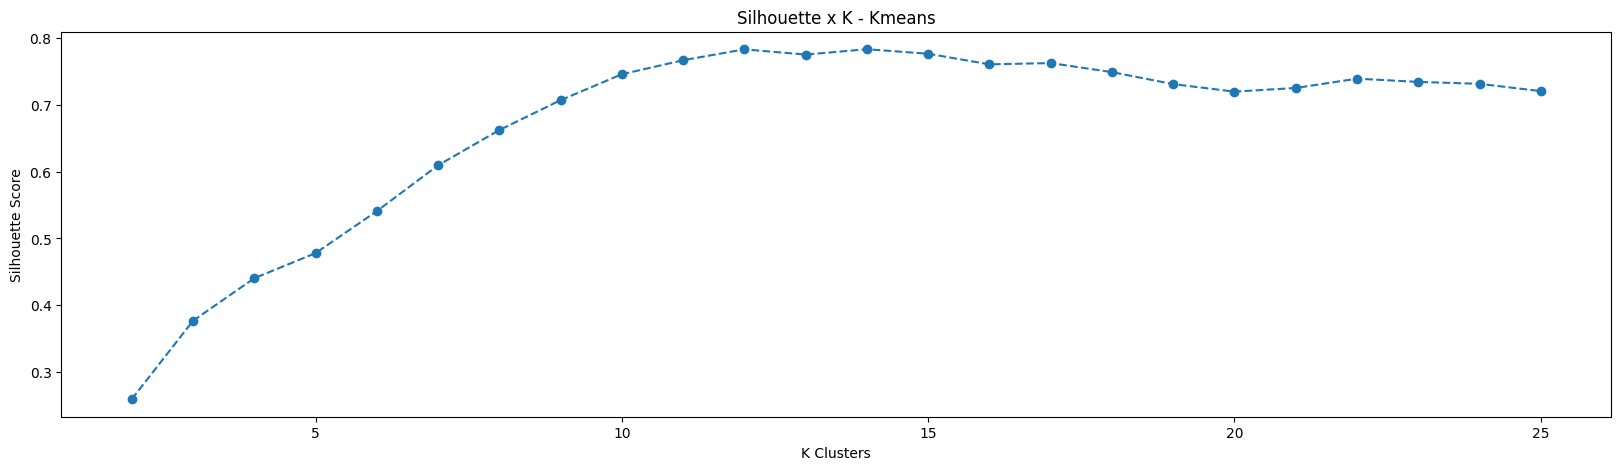

In [82]:
plt.figure(figsize=(20, 5))
plt.plot(clusters, kmeans_list, linestyle= '--', marker = 'o')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette x K - Kmeans')

## 7.2 GMM

In [83]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k)

    # model fit
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    ss = mt.silhouette_score(X, labels)
    gmm_list.append(ss)

Text(0.5, 1.0, 'Silhouette x K - GMM')

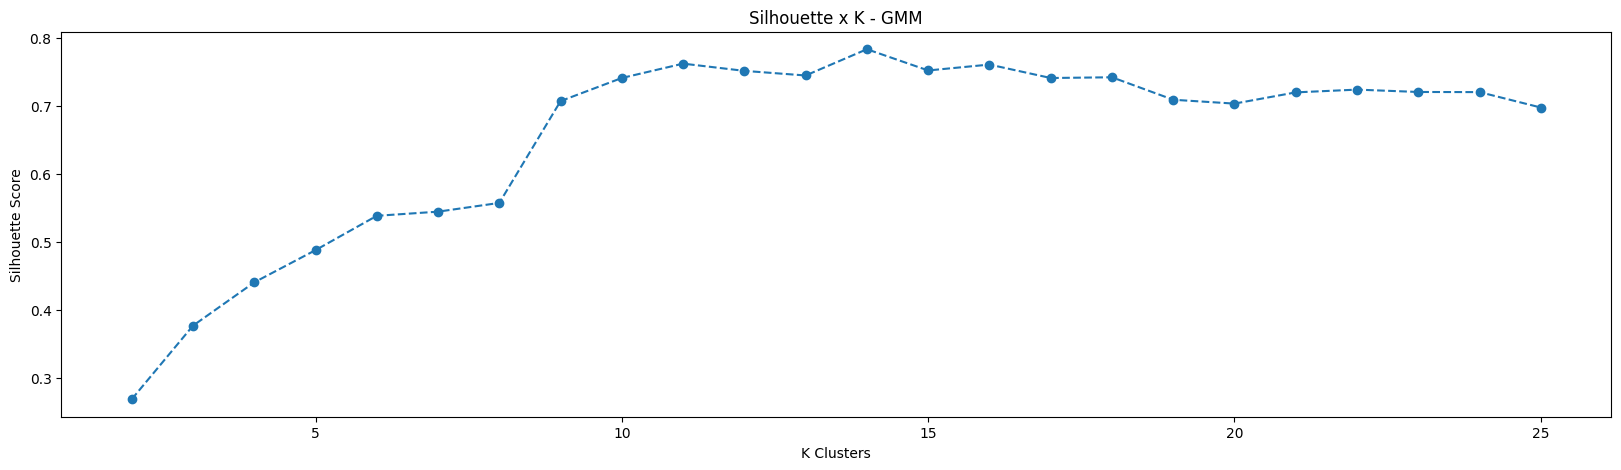

In [84]:
plt.figure(figsize=(20, 5))
plt.plot(clusters, gmm_list, linestyle= '--', marker = 'o')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette x K - GMM')

## 7.3 H-Clustering

### 7.3.1 Dendrogram

In [85]:
hclustering_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, method='ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = mt.silhouette_score(X, labels)
    hclustering_list.append(ss)

Text(0.5, 1.0, 'Silhouette x K - HClustering')

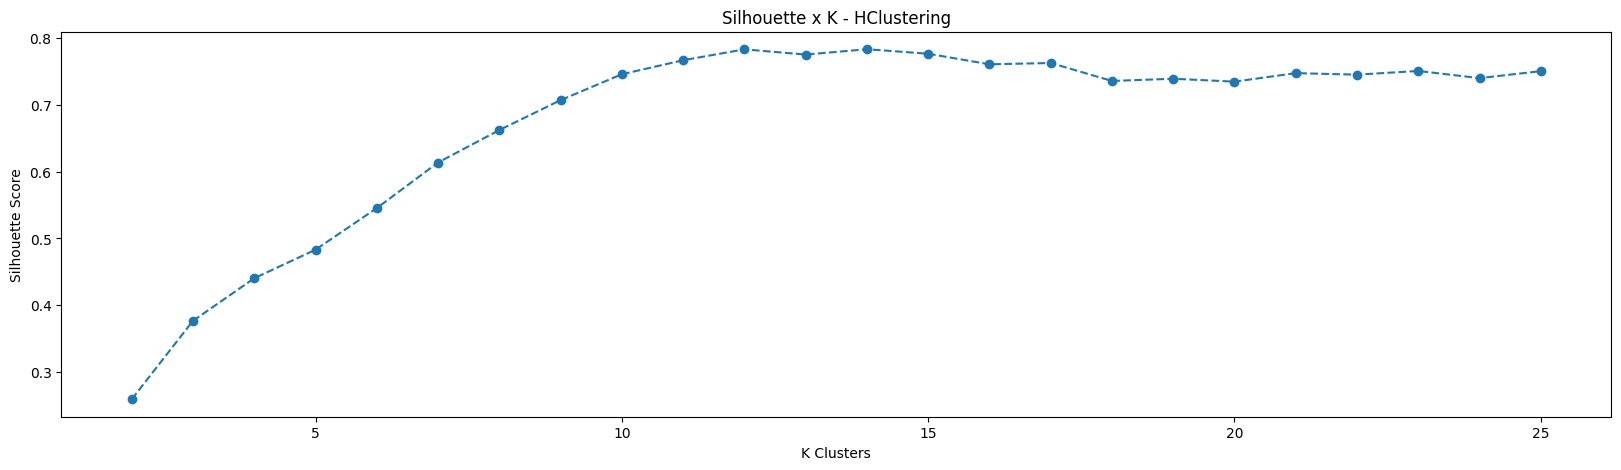

In [86]:
plt.figure(figsize=(20, 5))
plt.plot(clusters, hclustering_list, linestyle= '--', marker = 'o')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette x K - HClustering')

## 7.5 Results

In [87]:
df_results = pd.DataFrame(
    {'Kmeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hclustering_list
    }
).T
df_results.columns = clusters

In [88]:
df_results.style.highlight_max(color = 'blue', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Kmeans,0.259112,0.376584,0.440322,0.477872,0.540784,0.609471,0.662289,0.707065,0.745888,0.766883,0.783167,0.775340,0.783372,0.776581,0.760710,0.762634,0.749032,0.731080,0.719859,0.725337,0.739271,0.734415,0.731526,0.720590
GMM,0.268360,0.376584,0.440322,0.487745,0.538239,0.544359,0.557219,0.707065,0.741052,0.762171,0.751521,0.744731,0.783372,0.752114,0.760796,0.741020,0.742093,0.709028,0.703340,0.719876,0.723929,0.720467,0.720262,0.697571
HClustering,0.259112,0.376584,0.440322,0.483105,0.545353,0.613676,0.662289,0.707065,0.745888,0.766883,0.783167,0.775340,0.783372,0.776581,0.760796,0.762720,0.735815,0.739156,0.734802,0.747543,0.745275,0.750820,0.740046,0.750553


# 8.0 Model Training

## 8.1 K-Means

In [47]:
# model definition
k = 10

hc_model = hc.linkage(X, method='ward')

    # model predict
labels = hc.fcluster(hc_model, k, criterion='maxclust')



# 9.0 Cluster Analysis

In [48]:
cols_selected = ['customer_id','gross_revenue', 'recency_days', 
 'items_purchased',
 'avg_ticket',
 'number_returns', 'purchases'
]

In [49]:
df9 = df4[cols_selected].copy()
df9['cluster'] = labels
df9['items_purchased'] = df9['items_purchased'].astype(int)
df9['recency_days'] = df9['recency_days'].astype(int)
df9['number_returns'] = df9['number_returns'].astype(int)

## 9.2 Cluster Profile

In [50]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg gross_revenue
df_gross = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross, on='cluster', how='left')


# Avg recency_days
df_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, on='cluster', how='left')

# Avg purchases
df_purchases = df9[['purchases','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_purchases, on='cluster', how='left')

# Avg items_purchased
df_items_purchased = df9[['items_purchased','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_items_purchased, on='cluster', how='left')

# Avg number_returns
df_number_returns = df9[['number_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_number_returns, on='cluster', how='left')



df_cluster['avg_ticket'] = df_cluster.apply(lambda x: x['gross_revenue'] / x['purchases'], axis = 1)
df_cluster = df_cluster.drop('purchases', axis = 1)
df_cluster = np.round(df_cluster, 2)
df_cluster = df_cluster.sort_values('gross_revenue', ascending = False).reset_index(drop = True)
df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,items_purchased,number_returns,avg_ticket
0,10,291,9.81,14985.14,21.13,9055.00,4.09,775.09
1,9,175,5.90,3901.97,27.13,2325.30,1.69,419.70
2,8,365,12.30,2592.67,40.54,1588.74,1.31,383.90
3,5,331,11.16,1799.58,44.69,1057.24,0.98,343.52
4,6,242,8.16,1409.87,49.10,790.42,0.76,310.74
5,7,326,10.99,1070.53,61.33,589.20,0.78,284.66
6,1,252,8.49,842.95,70.87,441.69,0.57,259.37
7,2,512,17.26,592.36,86.88,293.97,0.49,220.57
8,4,237,7.99,431.12,132.49,144.71,0.62,231.69
9,3,236,7.95,237.94,103.94,111.90,0.31,97.49


- Cluster 6: Elite Insider
- Cluster 8: Elite Consumers
- Cluster 9: Peak Buyers
- Cluster 7: Significant Acquires
- Cluster 3 Occasional Consumers
- Cluster 4: Intermittent Shoppers
- Cluster 1: Sporadic Spenders
- Cluster 2: Rare Customers
- Cluster 5: Marginal Buyers

# 10.0 Deploy To Production

In [51]:
df10 = df9.drop(columns='purchases').copy()

## 10.1 Insert into SQLITe

In [67]:
# database connection
conn = create_engine('sqlite:///insiders.sqlite')
# create table
# query_create_table_insiders = """ 
#     CREATE TABLE insiders(
#         customer_id      INTEGER,
#         gross_revenue    REAL,
#         recency_days     INTEGER,
#         items_purchased  INTEGER,
#         avg_ticket       REAL,
#         number_returns   INTEGER,
#         cluster          INTEGER
#     )
# """

# conn.execute(query_create_table_insiders)
# conn.commit()
# conn.close()

# insert data
df10.to_sql('insiders', con = conn, if_exists= 'append', index = False)

# select data
# query = """
#     SELECT * FROM insiders
# """
# df = pd.read_sql_query(query, conn)